# String Db de interacción de proteínas

  * Origen de los datos: https://string-db.org/cgi/download.pl?sessionId=emyQzkygzVar&species_text=Homo+sapiens
  * Leemos las interacciones entre proteínas de StringDb
  * Las expresamos en nombres de genes
  * Conservamos las interacciones donde al menos un gen de los dos están en GWAS Catalog
  * Conservamos las interacciones de score alto (ojo que el score [viene multiplicado * 1000](http://version10.string-db.org/help/faq/#in-the-file-proteinlinkstxt-are-the-scores-multiplied-by-1000))

In [1]:
# !wget -c -P data https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz
# !wget -c -P data https://stringdb-static.org/download/protein.links.detailed.v11.0/9606.protein.links.detailed.v11.0.txt.gz
# !wget -c -P data https://stringdb-static.org/download/protein.links.full.v11.0/9606.protein.links.full.v11.0.txt.gz
# !wget -c -P data https://stringdb-static.org/download/protein.actions.v11.0/9606.protein.actions.v11.0.txt.gz
# !wget -c -P data https://stringdb-static.org/download/protein.info.v11.0/9606.protein.info.v11.0.txt.gz

In [2]:
%run imports.py

prot_info = pd.read_table("data/9606.protein.info.v11.0.txt.gz")

prot_links = pd.read_table("data/9606.protein.links.v11.0.txt.gz", sep="\s+")
prot_links = prot_links.rename(columns={"protein1": "ensembl_id_1", "protein2": "ensembl_id_2"})
prot_links["combined_score"] = prot_links.combined_score/1_000 # Viene * 1000 pero es una probabilidad (!)

ensemble_id_to_gene_symbol = dict(zip(prot_info.protein_external_id, prot_info.preferred_name))

print(f"{len(prot_links):,} enlaces descriptos (sin filtrar)")
prot_links.combined_score.plot.hist()

11,759,454 enlaces descriptos (sin filtrar)


  9%|▉         | 65254/725882 [00:00<00:01, 652537.51it/s]

725,882 enlaces descriptos INFO > 0.8


100%|██████████| 725882/725882 [00:00<00:00, 731727.02it/s]


722,144 enlaces descriptos con nombre de gen que no sea Ensembl ID


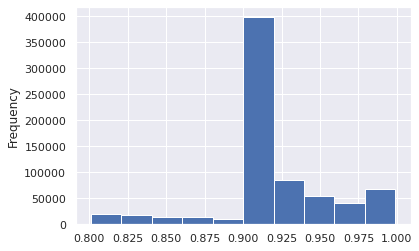

In [3]:
prot_links = prot_links.query("combined_score > 0.8")
print(f"{len(prot_links):,} enlaces descriptos INFO > 0.8")

prot_links["protein_1"] = prot_links.ensembl_id_1.progress_map(ensemble_id_to_gene_symbol.get)
prot_links["protein_2"] = prot_links.ensembl_id_2.progress_map(ensemble_id_to_gene_symbol.get)

still_ensembl_ids = (
    prot_links.protein_1.str.contains("ENS") |
    prot_links.protein_2.str.contains("ENS")
)

prot_links = prot_links[~still_ensembl_ids]
print(f"{len(prot_links):,} enlaces descriptos con nombre de gen que no sea Ensembl ID")

prot_links = prot_links.drop(["ensembl_id_1", "ensembl_id_2"], axis=1)

prot_links.combined_score.plot.hist()

In [4]:
gwas_cat = pd.read_table("results/gwas_cat.filtrado.tsv.gz")

genes_de_gwas = set(gwas_cat.gen_mapeado_elegido)

prot_links["protein_1_in_gwas"] = prot_links.protein_1.isin(genes_de_gwas)
prot_links["protein_2_in_gwas"] = prot_links.protein_2.isin(genes_de_gwas)

prot_links = prot_links.query("protein_1_in_gwas | protein_2_in_gwas")
print(f"{len(prot_links):,} enlaces de genes que estén en GWAS Catalog")

prot_links = prot_links.reset_index(drop=True)

fp = "results/prot_links.stringdb.tsv.gz"
cols_to_export = ["protein_1", "protein_2"]
prot_links[cols_to_export].to_csv(fp, sep="\t")

print(fp)
!zcat $fp | head -n5 | column -t

548,206 enlaces de genes que estén en GWAS Catalog
results/prot_links.stringdb.tsv.gz
protein_1  protein_2
0          ARF5       SPTBN2
1          ARF5       KIF13B
2          ARF5       TMED7
3          ARF5       ANK2

gzip: stdout: Broken pipe
